# <font color='red'><u><b>....Bike Sharing Assignment....</font>

In [1]:
# Warnings library imported to avoid displaying any warnings
import warnings
warnings.filterwarnings('ignore')

import math

# Pandas, Matplotlib, seaborn libraries imports
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns

# Scipy library imports
from scipy import stats
from scipy.stats import spearmanr

# Sklearn library imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error, r2_score

# Statsmodels library imports
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
# Data Loading

df = pd.read_csv('day.csv')
df.head()

instant      dteday  season  yr  mnth  holiday  weekday  workingday  \
0        1  01-01-2018       1   0     1        0        6           0   
1        2  02-01-2018       1   0     1        0        0           0   
2        3  03-01-2018       1   0     1        0        1           1   
3        4  04-01-2018       1   0     1        0        2           1   
4        5  05-01-2018       1   0     1        0        3           1   

   weathersit       temp     atemp      hum  windspeed  casual  registered  \
0           2  14.110847  18.18125  80.5833  10.749882     331         654   
1           2  14.902598  17.68695  69.6087  16.652113     131         670   
2           1   8.050924   9.47025  43.7273  16.636703     120        1229   
3           1   8.200000  10.60610  59.0435  10.739832     108        1454   
4           1   9.305237  11.46350  43.6957  12.522300      82        1518   

    cnt  
0   985  
1   801  
2  1349  
3  1562  
4  1600

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


## <font color='blue'><u>Data Manipulation

In [4]:
# Making 'instant' the index of this dataframe

df.set_index('instant', inplace=True)

In [5]:
# Renaming 'yr' column

df=df.rename(columns={'yr':'2019'})

In [6]:
# Converting to appropriate months in the respective column

def month_naming(x):
    mnth_nos=sorted(list((df.mnth.value_counts()).index))
    months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
    return months[mnth_nos.index(x)]

df.mnth=df.mnth.apply(lambda x: month_naming(x))

In [7]:
# Converting to appropriate weekdays in the respective column

def weekday_naming(x):
    weekday_nos=sorted(list((df.weekday.value_counts()).index))
    weekdays = ['Sun','Mon','Tue','Wed','Thu','Fri','Sat']
    return weekdays[weekday_nos.index(x)]

df.weekday=df.weekday.apply(lambda x: weekday_naming(x))

In [8]:
# Converting to appropriate seasons in the respective column

def season_naming(x):
    season_nos=sorted(list((df.season.value_counts()).index))
    seasons = ['Spring','Summer','Fall','Winter']
    return seasons[season_nos.index(x)]

df.season=df.season.apply(lambda x: season_naming(x))

In [9]:
# Converting to appropriate weathersit in the respective column

def weathersit_naming(x):
    weathersit_nos=sorted(list((df.weathersit.value_counts()).index))
    weathersits = ['Clear','Cloudy','Light precipitation','Heavy precipitation']
    return weathersits[weathersit_nos.index(x)]

df.weathersit=df.weathersit.apply(lambda x: weathersit_naming(x))

# 1: Clear, Few clouds, Partly cloudy, Partly cloudy                                         = 'Clear'
# 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist                            = 'Cloudy'
# 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds = 'Light precipitation'
# 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog                              = 'Heavy precipitation'

In [10]:
# Plots for distribution of categorical variables

plt.figure(figsize=(20, 12))

plt.subplot(3,3,1)
sns.boxplot(df.season,df.cnt)

plt.subplot(3,3,2)
sns.boxplot(df['2019'],df.cnt)

plt.subplot(3,3,3)
sns.boxplot(df.mnth,df.cnt)

plt.subplot(3,3,4)
sns.boxplot(df.holiday,df.cnt)

plt.subplot(3,3,5)
sns.boxplot(df.workingday,df.cnt)

plt.subplot(3,3,6)
sns.boxplot(df.weathersit,df.cnt)

plt.subplot(3,3,8)
sns.boxplot(df.weekday,df.cnt)

plt.show()

In [11]:
# Creating dummies

months = pd.get_dummies(df.mnth,drop_first=True)
weekdays = pd.get_dummies(df.weekday,drop_first=True)
seasons = pd.get_dummies(df.season,drop_first=True)
weathersits = pd.get_dummies(df.weathersit,drop_first=True)

df = pd.concat([df,months,weekdays,seasons,weathersits],axis=1)

df=df.drop(['dteday','mnth','weekday','season','weathersit'],axis=1)

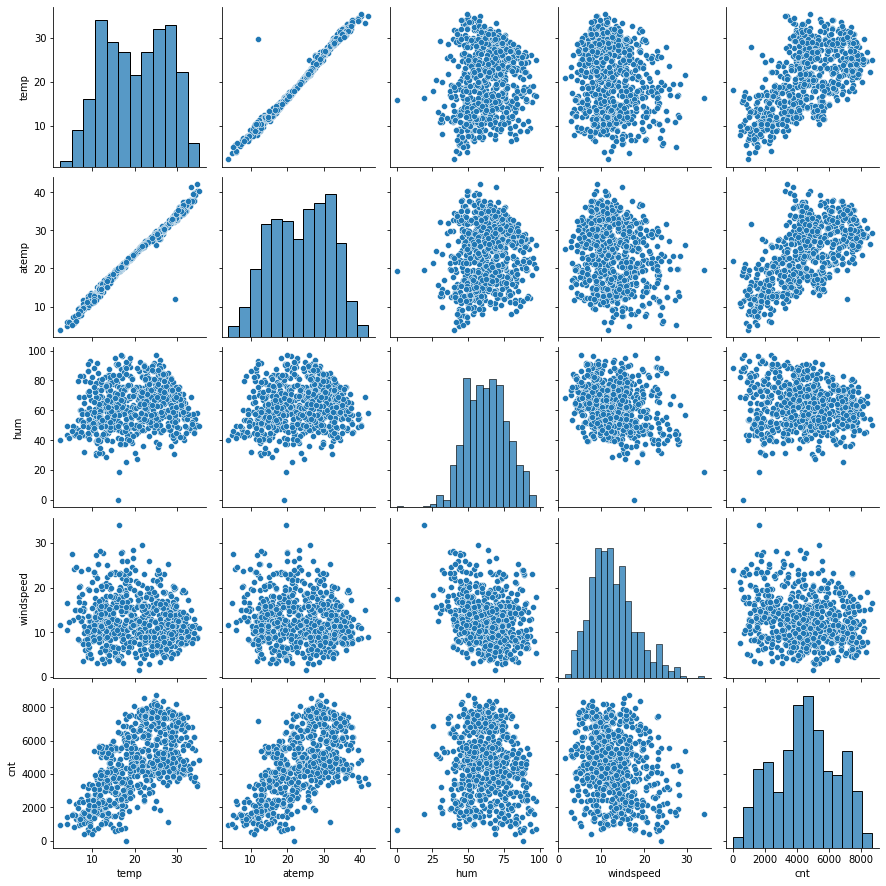

In [12]:
# Correlation and distribution of numeriacal variables

sns.pairplot(df[['temp','atemp','hum','windspeed','cnt']])
plt.show()

In [13]:
# Spearman's r coeff. and Pearson's r values of every predictor variable with the target variable 'cnt',
# in descending order.

variables_column, spearmanR_coef_column, pearsonsR_column = list(df.columns), [round(spearmanr(df[item],df.cnt)[0],3) for item in list(df.columns)], [round(np.corrcoef(df[item],df.cnt)[0][1],3) for item in list(df.columns)]

pearsonsR_df = pd.DataFrame({'Variables' : variables_column  , "Spearman's r coef." : spearmanR_coef_column, "Pearson's r" : pearsonsR_column})
pearsonsR_df = pearsonsR_df.sort_values(["Spearman's r coef.","Pearson's r"], ascending=False).set_index('Variables').drop('cnt',axis=0)

pearsonsR_df

Spearman's r coef.  Pearson's r
Variables                                           
registered                        0.940        0.945
casual                            0.753        0.672
atemp                             0.622        0.631
temp                              0.621        0.627
2019                              0.575        0.570
Jun                               0.205        0.196
Sep                               0.186        0.195
Aug                               0.182        0.182
Jul                               0.167        0.166
Summer                            0.148        0.145
May                               0.133        0.133
Oct                               0.107        0.109
workingday                        0.059        0.063
Winter                            0.057        0.065
Thu                               0.031        0.034
Wed                               0.019        0.014
Sat                               0.011        0.009
Tue                               0.005        0.001
Mon                              -0.037       -0.036
Nov                              -0.045       -0.040
Sun                              -0.059       -0.059
holiday                          -0.064       -0.069
hum                              -0.096       -0.099
Mar                              -0.123       -0.128
Dec                              -0.175       -0.174
Cloudy                           -0.179       -0.171
windspeed                        -0.217       -0.235
Light precipitation              -0.220       -0.241
Feb                              -0.281       -0.274
Jan                              -0.360       -0.367
Spring                           -0.557       -0.562

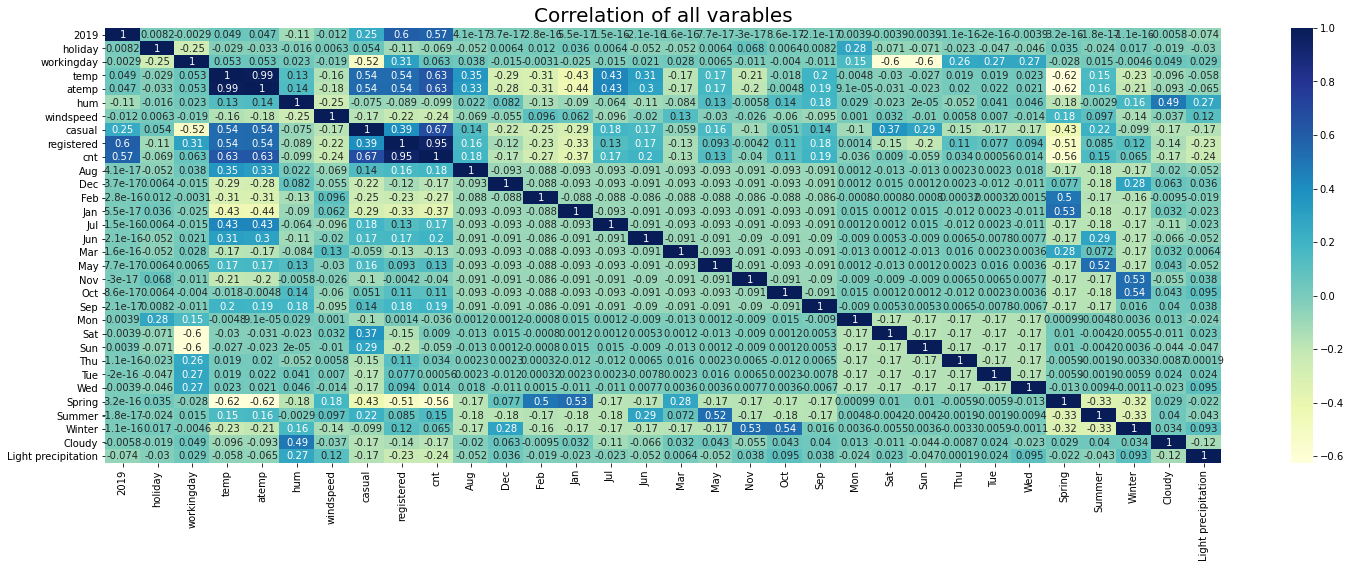

In [14]:
# Plot for Correlation of all varables

plt.figure(figsize=(25,8))
sns.heatmap(df.corr(),cmap='YlGnBu',annot=True)
plt.title('Correlation of all varables',fontsize=20)
plt.show()

## <font color='blue'><u>Model Building

In [15]:
# Splitting the data set into train and test data sets in a ratio of 7:3 and random state of 100

train,test =train_test_split(df,train_size=0.7,random_state=100)
train.head()

2019  holiday  workingday       temp    atemp      hum  windspeed  \
instant                                                                      
577         1        0           1  29.246653  33.1448  70.4167  11.083475   
427         1        0           0  16.980847  20.6746  62.1250  10.792293   
729         1        0           0  10.489153  11.5850  48.3333  23.500518   
483         1        0           0  15.443347  18.8752  48.9583   8.708325   
112         0        0           1  13.803347  16.0977  72.9583  14.707907   

         casual  registered   cnt  ...  Sat  Sun  Thu  Tue  Wed  Spring  \
instant                            ...                                    
577         968        6248  7216  ...    0    0    0    1    0       0   
427         956        3110  4066  ...    1    0    0    0    0       1   
729         364        1432  1796  ...    0    1    0    0    0       1   
483        1120        3100  4220  ...    1    0    0    0    0       0   
112         177        1506  1683  ...    0    0    0    0    0       0   

         Summer  Winter  Cloudy  Light precipitation  
instant                                               
577           0       0       0                    0  
427           0       0       1                    0  
729           0       0       0                    0  
483           1       0       1                    0  
112           1       0       1                    0  

[5 rows x 32 columns]

In [16]:
print('Shape of main dataframe is',df.shape)
print('Shape of train dataframe is',train.shape)
print('Shape of test dataframe is',test.shape)

Shape of main dataframe is (730, 32)
Shape of train dataframe is (510, 32)
Shape of test dataframe is (220, 32)


In [17]:
# Min-Max scaling of numerical variables of train data set

num_vars = ['temp','atemp','hum','windspeed','casual','registered','cnt']

scaler = MinMaxScaler()
train[num_vars] = scaler.fit_transform(train[num_vars])

train.describe()

2019     holiday  workingday        temp       atemp         hum  \
count  510.000000  510.000000  510.000000  510.000000  510.000000  510.000000   
mean     0.507843    0.025490    0.676471    0.537440    0.513156    0.650480   
std      0.500429    0.157763    0.468282    0.225858    0.212410    0.145846   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.339853    0.332086    0.538643   
50%      1.000000    0.000000    1.000000    0.542596    0.529718    0.653714   
75%      1.000000    0.000000    1.000000    0.735215    0.688457    0.754830   
max      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   

        windspeed      casual  registered         cnt  ...         Sat  \
count  510.000000  510.000000  510.000000  510.000000  ...  510.000000   
mean     0.320883    0.254689    0.523781    0.513499  ...    0.154902   
std      0.169803    0.206015    0.227896    0.224421  ...    0.362166   
min      0.000000    0.000000    0.000000    0.000000  ...    0.000000   
25%      0.199179    0.094179    0.353487    0.356420  ...    0.000000   
50%      0.296763    0.212740    0.525123    0.518638  ...    0.000000   
75%      0.414447    0.327415    0.696073    0.684710  ...    0.000000   
max      1.000000    1.000000    1.000000    1.000000  ...    1.000000   

              Sun         Thu         Tue         Wed      Spring      Summer  \
count  510.000000  510.000000  510.000000  510.000000  510.000000  510.000000   
mean     0.143137    0.133333    0.131373    0.158824    0.243137    0.247059   
std      0.350557    0.340268    0.338139    0.365870    0.429398    0.431725   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
75%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
max      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   

           Winter      Cloudy  Light precipitation  
count  510.000000  510.000000           510.000000  
mean     0.247059    0.345098             0.029412  
std      0.431725    0.475867             0.169124  
min      0.000000    0.000000             0.000000  
25%      0.000000    0.000000             0.000000  
50%      0.000000    0.000000             0.000000  
75%      0.000000    1.000000             0.000000  
max      1.000000    1.000000             1.000000  

[8 rows x 32 columns]

In [18]:
# Function to calculate VIF

def VIF(df):
    vif = pd.DataFrame()
    vif['Features'] = df.columns
    vif['VIF'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    return vif

In [19]:
# Selecting 'cnt' as target variable and rest as predictor variabes from train data set

y_train = train.pop('cnt')
X_train = train

print('There are',len(X_train.columns),'features to select among.')

There are 31 features to select among.


In [20]:
# RFE is used to determine the significant features

lm = LinearRegression().fit(X_train,y_train)

rfe = RFE(lm,28).fit(X_train,y_train)

# list(zip(X_train.columns,rfe.support_,rfe.ranking_))

# Columns are selected based on the RFE result
col = X_train.columns[rfe.support_]

print('The best',len(col),'columns choses through RFE are:-\n',list(col))

The best 28 columns choses through RFE are:-
 ['2019', 'holiday', 'workingday', 'temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered', 'Aug', 'Dec', 'Feb', 'Jan', 'Jul', 'Mar', 'May', 'Sep', 'Mon', 'Sat', 'Sun', 'Thu', 'Tue', 'Wed', 'Spring', 'Summer', 'Winter', 'Cloudy', 'Light precipitation']


#### Running 1st model

In [21]:
new_rfe = X_train[col]

# 'const' variable is added
X_train_sm = sm.add_constant(new_rfe)

# Model is built based on the columns suggested by RFE
rfe_sm_model = sm.OLS(y_train,X_train_sm).fit()

print(rfe_sm_model.summary())
VIF(new_rfe)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 7.849e+30
Date:                Thu, 29 Jul 2021   Prob (F-statistic):               0.00
Time:                        00:34:55   Log-Likelihood:                 17444.
No. Observations:                 510   AIC:                        -3.483e+04
Df Residuals:                     482   BIC:                        -3.471e+04
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                3.053e-16    

Features    VIF
2            workingday  82.18
3                  temp  62.15
4                 atemp  55.03
18                  Sat  18.06
19                  Sun  16.31
23               Spring  10.50
8            registered   7.65
24               Summer   6.58
25               Winter   6.56
7                casual   4.34
12                  Jan   4.04
1               holiday   3.88
0                  2019   3.21
9                   Aug   3.18
11                  Feb   3.05
13                  Jul   2.82
14                  Mar   2.35
16                  Sep   2.24
5                   hum   2.06
17                  Mon   2.00
22                  Wed   2.00
20                  Thu   1.85
21                  Tue   1.83
26               Cloudy   1.70
10                  Dec   1.67
15                  May   1.59
27  Light precipitation   1.55
6             windspeed   1.41

In [22]:
print((df.registered+df.casual==df.cnt).value_counts())

True    730
dtype: int64


### <font color='green'><b>From the above code it can be seen that addition of registered and casual is equal to cnt. Since, there is direct involvement of 'registered' and 'casual' features, they cannot be considered in model and hence is dropped. (Target Leakage)

#### Running 2nd model

In [23]:
remove_columns = ['registered','casual']
print('Features to be removed are',remove_columns,'\n\n')

new_rfe = X_train[new_rfe.columns].drop(remove_columns,axis=1)

# 'const' variable is added
X_train_sm = sm.add_constant(new_rfe)

# Model is built based on new_rfe
rfe_sm_model = sm.OLS(y_train,X_train_sm).fit()

print(rfe_sm_model.summary())
VIF(new_rfe)

Features to be removed are ['registered', 'casual'] 


                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.851
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     110.4
Date:                Thu, 29 Jul 2021   Prob (F-statistic):          4.17e-182
Time:                        00:34:56   Log-Likelihood:                 524.11
No. Observations:                 510   AIC:                            -996.2
Df Residuals:                     484   BIC:                            -886.1
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------

Features    VIF
2            workingday  69.77
3                  temp  60.74
4                 atemp  54.96
16                  Sat  15.94
17                  Sun  14.93
21               Spring  10.39
22               Summer   6.47
23               Winter   6.25
10                  Jan   4.01
1               holiday   3.71
7                   Aug   3.17
9                   Feb   3.03
11                  Jul   2.81
12                  Mar   2.35
14                  Sep   2.16
5                   hum   1.99
15                  Mon   1.98
20                  Wed   1.93
18                  Thu   1.82
19                  Tue   1.79
8                   Dec   1.63
24               Cloudy   1.59
13                  May   1.58
25  Light precipitation   1.29
6             windspeed   1.27
0                  2019   1.05

### <font color='green'><b>'Jan', 'Feb', 'Mar', 'May', 'Jul', 'Aug', 'Dec' have high P-values

#### Running 3rd model

In [24]:
remove_columns = ['Jan', 'Feb', 'Mar', 'May', 'Jul', 'Aug', 'Dec']
print('Features to be removed are',remove_columns,'\n\n')

new_rfe = X_train[new_rfe.columns].drop(remove_columns,axis=1)

# 'const' variable is added
X_train_sm = sm.add_constant(new_rfe)

# Model is built based on new_rfe
rfe_sm_model = sm.OLS(y_train,X_train_sm).fit()

print(rfe_sm_model.summary())
VIF(new_rfe)

Features to be removed are ['Jan', 'Feb', 'Mar', 'May', 'Jul', 'Aug', 'Dec'] 


                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     148.7
Date:                Thu, 29 Jul 2021   Prob (F-statistic):          1.58e-185
Time:                        00:34:57   Log-Likelihood:                 514.36
No. Observations:                 510   AIC:                            -990.7
Df Residuals:                     491   BIC:                            -910.3
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------

Features    VIF
3                  temp  58.89
4                 atemp  54.22
2            workingday  53.62
9                   Sat  12.07
10                  Sun  11.64
14               Spring   4.93
16               Winter   3.40
1               holiday   3.16
15               Summer   2.39
8                   Mon   1.97
13                  Wed   1.93
5                   hum   1.91
11                  Thu   1.81
12                  Tue   1.79
17               Cloudy   1.58
18  Light precipitation   1.26
6             windspeed   1.24
7                   Sep   1.19
0                  2019   1.04

### <font color='green'><b>'Mon', 'Tue', 'Wed', 'Thu' have high P-values

#### Running 4th model

In [25]:
remove_columns = ['Mon', 'Tue', 'Wed', 'Thu']
print('Features to be removed are',remove_columns,'\n\n')

new_rfe = X_train[new_rfe.columns].drop(remove_columns,axis=1)

# 'const' variable is added
X_train_sm = sm.add_constant(new_rfe)

# Model is built based on new_rfe
rfe_sm_model = sm.OLS(y_train,X_train_sm).fit()

print(rfe_sm_model.summary())
VIF(new_rfe)

Features to be removed are ['Mon', 'Tue', 'Wed', 'Thu'] 


                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     191.6
Date:                Thu, 29 Jul 2021   Prob (F-statistic):          1.89e-189
Time:                        00:34:57   Log-Likelihood:                 512.96
No. Observations:                 510   AIC:                            -995.9
Df Residuals:                     495   BIC:                            -932.4
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------

Features    VIF
3                  temp  58.09
4                 atemp  53.54
2            workingday  50.01
8                   Sat  12.03
9                   Sun  11.60
10               Spring   4.91
12               Winter   3.40
1               holiday   2.89
11               Summer   2.38
5                   hum   1.90
13               Cloudy   1.57
14  Light precipitation   1.25
6             windspeed   1.24
7                   Sep   1.19
0                  2019   1.03

### <font color='green'><b>'atemp' has high P-value and VIF

#### Running 5th model

In [26]:
remove_columns = ['atemp']
print('Features to be removed are',remove_columns,'\n\n')

new_rfe = X_train[new_rfe.columns].drop(remove_columns,axis=1)

# 'const' variable is added
X_train_sm = sm.add_constant(new_rfe)

# Model is built based on new_rfe
rfe_sm_model = sm.OLS(y_train,X_train_sm).fit()

print(rfe_sm_model.summary())
VIF(new_rfe)

Features to be removed are ['atemp'] 


                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     206.7
Date:                Thu, 29 Jul 2021   Prob (F-statistic):          1.29e-190
Time:                        00:34:58   Log-Likelihood:                 512.96
No. Observations:                 510   AIC:                            -997.9
Df Residuals:                     496   BIC:                            -938.6
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------

Features    VIF
2            workingday  49.97
7                   Sat  12.02
8                   Sun  11.60
9                Spring   4.84
3                  temp   3.53
11               Winter   3.27
1               holiday   2.88
10               Summer   2.29
4                   hum   1.90
12               Cloudy   1.57
13  Light precipitation   1.25
5             windspeed   1.20
6                   Sep   1.19
0                  2019   1.03

### <font color='green'><b>'holiday' has high P-value

#### Running 6th model

In [27]:
remove_columns = ['holiday']
print('Features to be removed are',remove_columns,'\n\n')

new_rfe = X_train[new_rfe.columns].drop(remove_columns,axis=1)

# 'const' variable is added
X_train_sm = sm.add_constant(new_rfe)

# Model is built based on new_rfe
rfe_sm_model = sm.OLS(y_train,X_train_sm).fit()

print(rfe_sm_model.summary())
VIF(new_rfe)

Features to be removed are ['holiday'] 


                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     206.7
Date:                Thu, 29 Jul 2021   Prob (F-statistic):          1.29e-190
Time:                        00:34:58   Log-Likelihood:                 512.96
No. Observations:                 510   AIC:                            -997.9
Df Residuals:                     496   BIC:                            -938.6
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------

Features    VIF
3                   hum  32.08
1            workingday  18.30
2                  temp  18.06
4             windspeed   4.90
6                   Sat   4.88
7                   Sun   4.72
8                Spring   4.66
10               Winter   3.49
9                Summer   2.67
11               Cloudy   2.31
0                  2019   2.09
5                   Sep   1.27
12  Light precipitation   1.25

### <font color='green'><b>'hum' has high VIF

#### Running 7th model

In [28]:
remove_columns = ['hum']
print('Features to be removed are',remove_columns,'\n\n')

new_rfe = X_train[new_rfe.columns].drop(remove_columns,axis=1)

# 'const' variable is added
X_train_sm = sm.add_constant(new_rfe)

# Model is built based on new_rfe
rfe_sm_model = sm.OLS(y_train,X_train_sm).fit()

print(rfe_sm_model.summary())
VIF(new_rfe)

Features to be removed are ['hum'] 


                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                     215.7
Date:                Thu, 29 Jul 2021   Prob (F-statistic):          3.16e-188
Time:                        00:34:58   Log-Likelihood:                 504.48
No. Observations:                 510   AIC:                            -983.0
Df Residuals:                     497   BIC:                            -927.9
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------

Features    VIF
1            workingday  16.10
2                  temp  11.93
3             windspeed   4.76
5                   Sat   4.42
6                   Sun   4.18
7                Spring   3.66
9                Winter   2.56
8                Summer   2.37
0                  2019   2.07
10               Cloudy   1.58
4                   Sep   1.23
11  Light precipitation   1.09

### <font color='green'><b>'workingday' has high VIF

#### Running 8th model

In [29]:
remove_columns = ['workingday']
print('Features to be removed are',remove_columns,'\n\n')

new_rfe = X_train[new_rfe.columns].drop(remove_columns,axis=1)

# 'const' variable is added
X_train_sm = sm.add_constant(new_rfe)

# Model is built based on new_rfe
rfe_sm_model = sm.OLS(y_train,X_train_sm).fit()

print(rfe_sm_model.summary())
VIF(new_rfe)

Features to be removed are ['workingday'] 


                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.830
Method:                 Least Squares   F-statistic:                     227.3
Date:                Thu, 29 Jul 2021   Prob (F-statistic):          3.96e-186
Time:                        00:34:59   Log-Likelihood:                 496.68
No. Observations:                 510   AIC:                            -969.4
Df Residuals:                     498   BIC:                            -918.6
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

Features   VIF
2             windspeed  4.62
1                  temp  3.96
0                  2019  2.07
6                Spring  2.02
7                Summer  1.91
8                Winter  1.65
9                Cloudy  1.55
3                   Sep  1.22
4                   Sat  1.22
5                   Sun  1.21
10  Light precipitation  1.08

In [30]:
print('The final',len(new_rfe.columns),'best columns choses through RFE are:-\n',list(new_rfe.columns))

The final 11 best columns choses through RFE are:-
 ['2019', 'temp', 'windspeed', 'Sep', 'Sat', 'Sun', 'Spring', 'Summer', 'Winter', 'Cloudy', 'Light precipitation']


### <font color='green'><b>RFE and model tweaking have finally provided the above columns that will bring substantial significance to the model.
### <font color='green'><b>Therefore, the above features are chosen since they provide substantial significance.
### <font color='green'><b>After multiple tweakings and trials with the above features, it is observed that if 'Sat' is replaced with 'holiday', overall P-value and VIF value of features, R-squared, Adj. R-squared, F-statistics improve drastically. Hence 'Sat' has been replaced with 'holiday'.

#### Running 9th model (final model)

In [31]:
# Above features are taken. 'Sat' is replaced with 'holiday'

# Below 3 lines of codes are to add and remove features with ease and without loosing the basic choosen features
# Enter below the features to remove
remove_features = ['Sat']
# Enter features below to add
add_features = ['holiday']
new_cols = [x for x in list(new_rfe.columns) if x not in remove_features]+add_features

new = X_train[new_cols]

# 'const' variable is added
X_train_sm = sm.add_constant(new)

sm_model = sm.OLS(y_train,X_train_sm).fit()

print(sm_model.summary())
VIF(new)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                     235.2
Date:                Thu, 29 Jul 2021   Prob (F-statistic):          3.23e-189
Time:                        00:34:59   Log-Likelihood:                 503.99
No. Observations:                 510   AIC:                            -984.0
Df Residuals:                     498   BIC:                            -933.2
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.1981    

Features   VIF
2             windspeed  4.60
1                  temp  3.91
0                  2019  2.07
5                Spring  2.02
6                Summer  1.91
7                Winter  1.66
8                Cloudy  1.55
3                   Sep  1.23
4                   Sun  1.18
9   Light precipitation  1.08
10              holiday  1.05

In [32]:
print('According to the model "sm_model" built and its statistical datas, following are the',len(new_cols),'best features that describe and predict the best :-\n',new_cols)

According to the model "sm_model" built and its statistical datas, following are the 11 best features that describe and predict the best :-
 ['2019', 'temp', 'windspeed', 'Sep', 'Sun', 'Spring', 'Summer', 'Winter', 'Cloudy', 'Light precipitation', 'holiday']


### <font color='green'><b>According to the model "sm_model" built and its statistical datas, following are the 11 best features that describe and predict the best :-
### <font color='green'><b>[2019, 'temp', 'windspeed', 'Sep', 'Sun', 'Spring', 'Summer', 'Winter', 'Cloudy', 'Light precipitation', 'holiday']


## <font color='blue'><u>Evaluation and Prediction

In [33]:
# Split is performed again in order to allow to re-run the code since in a later cell 'cnt' is popped out from
# test data set
train,test =train_test_split(df,train_size=0.7,random_state=100)

# Min-Max scaling transformation of numerical variables of train data set
test[num_vars] = scaler.transform(test[num_vars])
test.head()

2019  holiday  workingday      temp     atemp       hum  windspeed  \
instant                                                                       
185         0        1           0  0.831783  0.769660  0.657364   0.084219   
536         1        0           1  0.901354  0.842587  0.610133   0.153728   
300         0        0           1  0.511964  0.496145  0.837699   0.334206   
222         0        0           1  0.881625  0.795343  0.437098   0.339570   
153         0        0           1  0.817246  0.741471  0.314298   0.537414   

           casual  registered       cnt  ...  Sat  Sun  Thu  Tue  Wed  Spring  \
instant                                  ...                                    
185      0.933557    0.427086  0.692706  ...    0    0    0    0    0       0   
536      0.265163    0.767976  0.712034  ...    0    0    0    0    1       0   
300      0.072539    0.346376  0.303382  ...    0    0    1    0    0       0   
222      0.268820    0.559630  0.547400  ...    0    0    0    0    1       0   
153      0.223712    0.608143  0.569029  ...    0    0    1    0    0       0   

         Summer  Winter  Cloudy  Light precipitation  
instant                                               
185           0       0       1                    0  
536           1       0       0                    0  
300           0       1       1                    0  
222           0       0       0                    0  
153           1       0       0                    0  

[5 rows x 32 columns]

In [34]:
# Selecting 'cnt' as target variable and rest as predictor variabes from test data set
y_test = test.pop('cnt')
X_test = test[new.columns]


# 'const' variable is added
X_test_sm = sm.add_constant(X_test)

In [35]:
# Train and test target values are predicted

y_train_pred=sm_model.predict(X_train_sm)
y_test_pred=sm_model.predict(X_test_sm)

In [36]:
# Residual calculations for train data set and test data set predictions

train_residual = y_train-y_train_pred
test_residual = y_test-y_test_pred

In [37]:
# Residual Sum of Squares (RSS)

RSS_train = round(sum(train_residual**2),2)
RSS_test = round(sum(test_residual**2),2)

print('RSS of train data set =',RSS_train)
print('RSS of test data set =',RSS_test)

RSS of train data set = 4.14
RSS of test data set = 2.03


In [38]:
# Residual Square Errors (RSE)

RSE_train = round(math.sqrt(RSS_train/(len(train_residual)-2)),2)
RSE_test = round(math.sqrt(RSS_test/(len(test_residual)-2)),2)

print('RSE of train data set =',RSE_train)
print('RSE of test data set =',RSE_test)

RSE of train data set = 0.09
RSE of test data set = 0.1


In [39]:
# Mean Squared Error

MSE_train = round(mean_squared_error(y_train,y_train_pred),3)
MSE_test = round(mean_squared_error(y_test,y_test_pred),3)

print('MSE of train data set =',MSE_train)
print('MSE of test data set =',MSE_test)

MSE of train data set = 0.008
MSE of test data set = 0.009


In [40]:
# R-squared

Rsq_train = round(r2_score(y_train,y_train_pred),3)
Rsq_test = round(r2_score(y_test,y_test_pred),3)

print('R-squared of train data set =',Rsq_train)
print('R-squared of test data set =',Rsq_test)

R-squared of train data set = 0.839
R-squared of test data set = 0.807


- ### <font color='green'><b>RSS of train data set = 4.14
### <font color='green'><b>RSS of test data set = 2.03<br>
- ### <font color='green'><b>RSE of train data set = 0.09
### <font color='green'><b>RSE of test data set = 0.1<br>
- ### <font color='green'><b>MSE of train data set = 0.008
### <font color='green'><b>MSE of test data set = 0.009<br>
- ### <font color='green'><b>R-squared of train data set = 0.839
### <font color='green'><b>R-squared of test data set = 0.807

### Creating a data frame with the 'test' predicted values

In [41]:
# Merging the predicted values in test data set
test['cnt'] = y_test_pred

# Inversing the scaling transformation
test[num_vars] = scaler.inverse_transform(test[num_vars])

# Renaming the 'cnt' column
test = test.rename(columns={'cnt' : 'cnt_predicted'})

In [42]:
test.head()

2019  holiday  workingday       temp     atemp      hum  windspeed  \
instant                                                                       
185         0        1           0  29.793347  33.27085  63.7917   5.459106   
536         1        0           1  32.082500  36.04875  59.2083   7.625404   
300         0        0           1  19.270000  22.85230  81.2917  13.250121   
222         0        0           1  31.433347  34.24915  42.4167  13.417286   
153         0        0           1  29.315000  32.19710  30.5000  19.583229   

         casual  registered  Aug  ...  Sun  Thu  Tue  Wed  Spring  Summer  \
instant                           ...                                       
185      3065.0      2978.0    0  ...    0    0    0    0       0       0   
536       872.0      5339.0    0  ...    0    0    0    1       0       1   
300       240.0      2419.0    0  ...    0    1    0    0       0       0   
222       884.0      3896.0    1  ...    0    0    0    1       0       0   
153       736.0      4232.0    0  ...    0    1    0    0       0       1   

         Winter  Cloudy  Light precipitation  cnt_predicted  
instant                                                      
185           0       1                    0    3482.703613  
536           0       0                    0    7867.463896  
300           1       1                    0    3580.725665  
222           0       0                    0    4971.062807  
153           0       0                    0    4990.315143  

[5 rows x 32 columns]

## <font color='blue'><u>Visualisation

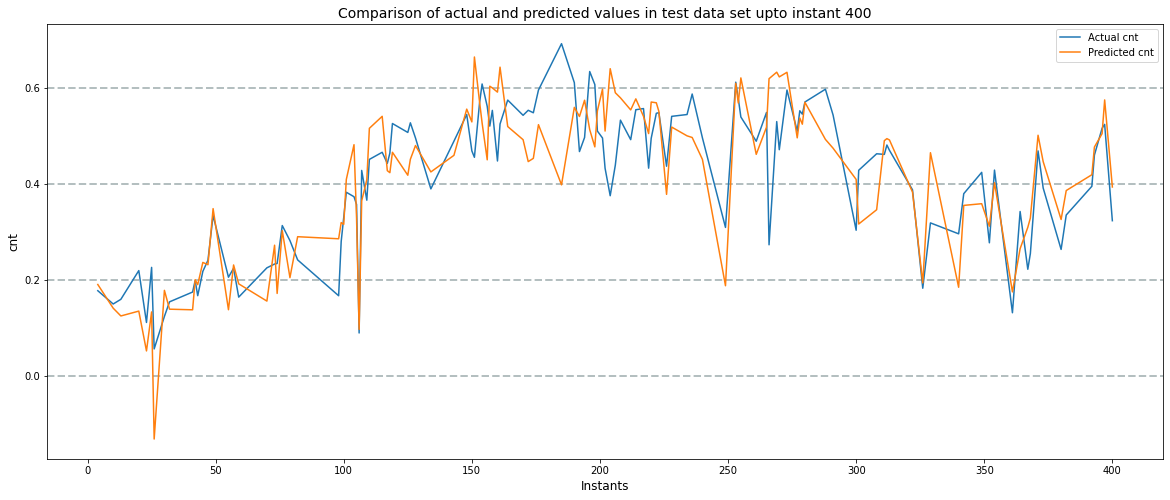

In [43]:
# Plots for Comparison of actual and predicted values in train and test data sets upto instant {n}

n = 400

train_pred=pd.concat([y_train,y_train_pred],axis=1).rename(columns={'cnt':'act',0:'pred'})
plt.figure(figsize=(20,8))
plt.plot(train_pred.sort_index()[train_pred.sort_index().index<=n].act,label='Actual cnt')
plt.plot(train_pred.sort_index()[train_pred.sort_index().index<=n].pred,label='Predicted cnt')
plt.title(f'Comparison of actual and predicted values in train data set upto instant {n}',fontsize=14)
plt.xlabel('Instants',fontsize=12)
plt.ylabel('cnt',fontsize=12)
plt.grid(color='#95a5a6', linestyle='--', linewidth=2, axis='y', alpha=0.7)
plt.legend()
plt.show()

print('\n\n')

test_pred=pd.concat([y_test,y_test_pred],axis=1).rename(columns={'cnt':'act',0:'pred'})
plt.figure(figsize=(20,8))
plt.plot(test_pred.sort_index()[test_pred.sort_index().index<=n].act,label='Actual cnt')
plt.plot(test_pred.sort_index()[test_pred.sort_index().index<=n].pred,label='Predicted cnt')
plt.title(f'Comparison of actual and predicted values in test data set upto instant {n}',fontsize=14)
plt.xlabel('Instants',fontsize=12)
plt.ylabel('cnt',fontsize=12)
plt.grid(color='#95a5a6', linestyle='--', linewidth=2, axis='y', alpha=0.7)
plt.legend()
plt.show()

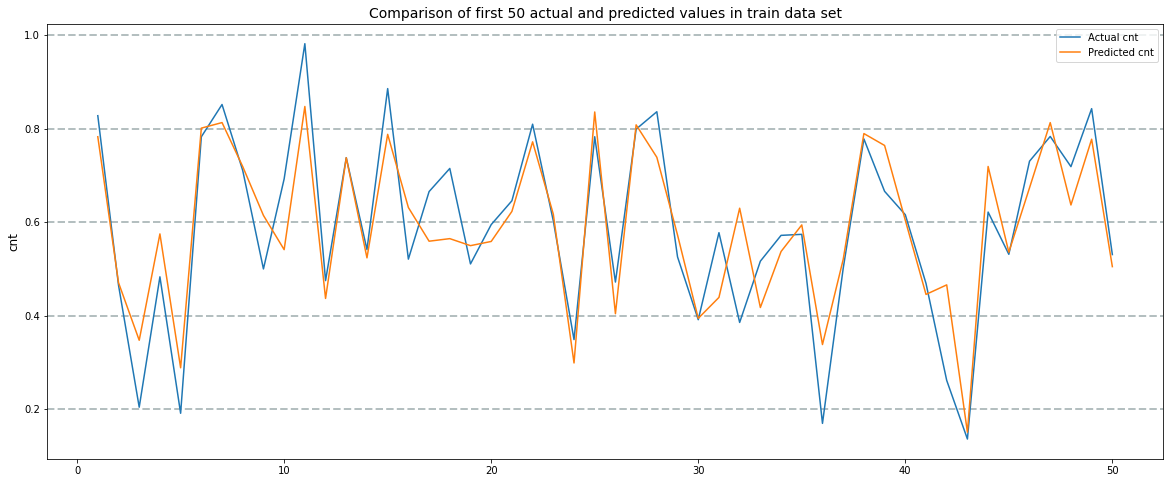

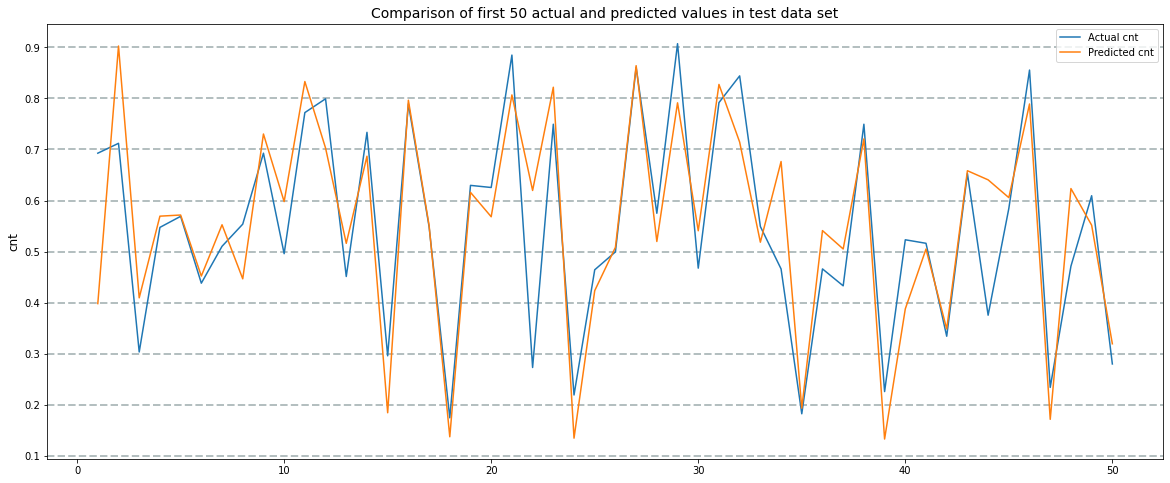

In [44]:
# Plots for Comparison of first n actual and predicted values

n = 50

new_train_pred=train_pred.iloc[:n,:]
plt.figure(figsize=(20,8))
plt.plot([i for i in range(1,len(new_train_pred)+1,1)],new_train_pred.act,label='Actual cnt')
plt.plot([i for i in range(1,len(new_train_pred)+1,1)],new_train_pred.pred,label='Predicted cnt')
plt.title(f'Comparison of first {n} actual and predicted values in train data set',fontsize=14)
plt.ylabel('cnt',fontsize=12)
plt.grid(color='#95a5a6', linestyle='--', linewidth=2, axis='y', alpha=0.7)
plt.legend()
plt.show()

print('\n\n')

new_test_pred=test_pred.iloc[:n,:]
plt.figure(figsize=(20,8))
plt.plot([i for i in range(1,len(new_test_pred)+1,1)],new_test_pred.act,label='Actual cnt')
plt.plot([i for i in range(1,len(new_test_pred)+1,1)],new_test_pred.pred,label='Predicted cnt')
plt.title(f'Comparison of first {n} actual and predicted values in test data set',fontsize=14)
plt.ylabel('cnt',fontsize=12)
plt.grid(color='#95a5a6', linestyle='--', linewidth=2, axis='y', alpha=0.7)
plt.legend()
plt.show()

### <font color='green'><b>It is clearly visible that the actual and predicted values match at a great exten in both train and test data sets.<br><br>

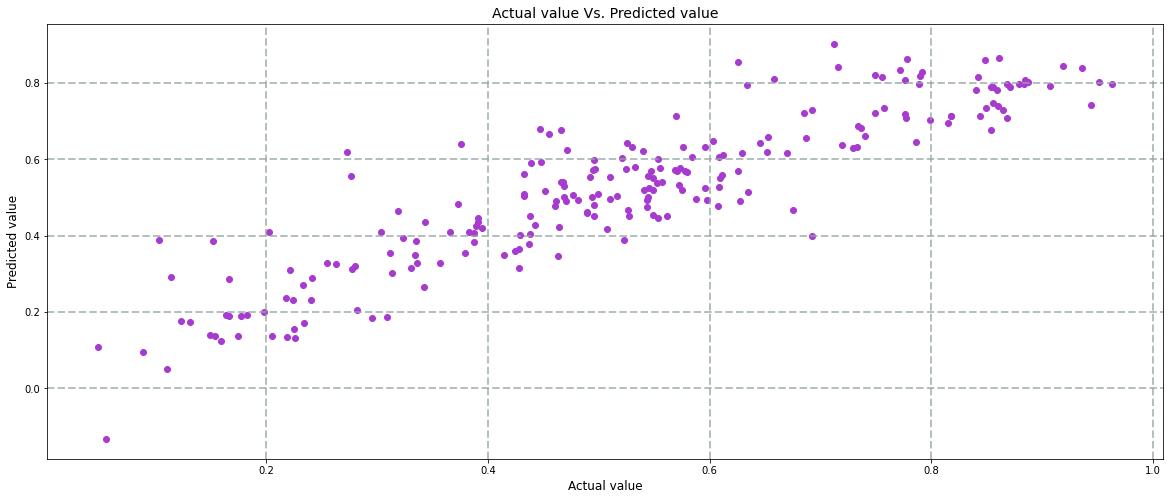

In [45]:
# Plot for Actual value Vs. Predicted value

plt.figure(figsize=(20,8))
plt.scatter(y_test,y_test_pred,color='#a73acf')
plt.title('Actual value Vs. Predicted value',fontsize=14)
plt.xlabel('Actual value',fontsize=12)
plt.ylabel('Predicted value',fontsize=12)
plt.grid(color='#95a5a6', linestyle='--', linewidth=2, alpha=0.7)
plt.show()

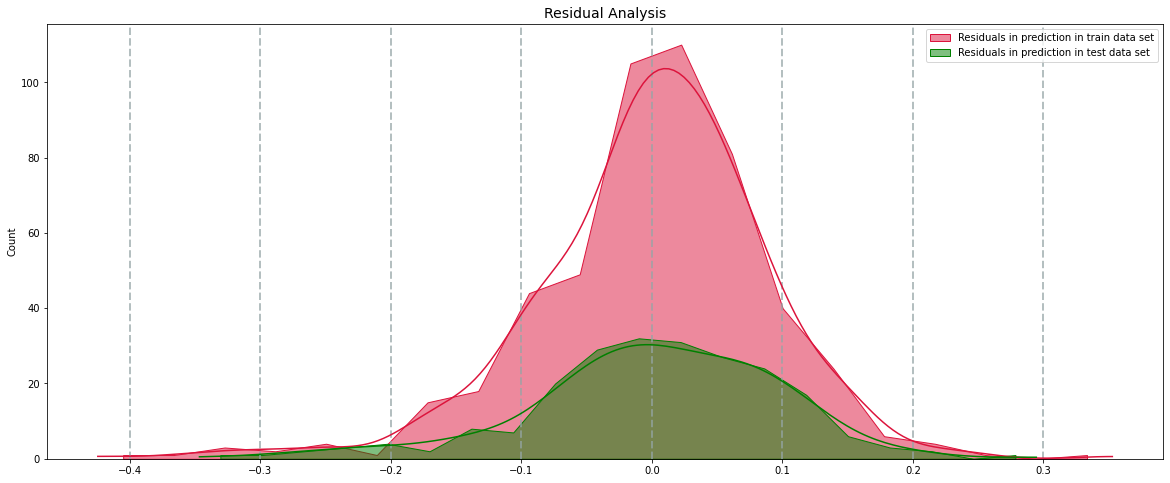

In [46]:
# Plots for residual analysis
plt.figure(figsize=(20,8))
sns.histplot(train_residual,bins=20,element='poly',color='crimson',kde=True,label='Residuals in prediction in train data set')
sns.histplot(test_residual,bins=20,element='poly',color='green',kde=True,label='Residuals in prediction in test data set')
plt.title('Residual Analysis',fontsize=14)
plt.grid(color='#95a5a6', linestyle='--', linewidth=2, axis='x', alpha=0.7)
plt.legend()
plt.show()

print('\n\n')

# Plot for Q-Q plot for test data set prediction residuals compared to normal distribution
plt.figure(figsize=(20,8))
stats.probplot(test_residual,dist="norm",plot=plt)
plt.title('Q-Q plot for residuals from test data set prediction, compared to normal distribution',fontsize=14)
plt.show()

### <font color='green'><b>Residuals are normally distributed.<br><br>

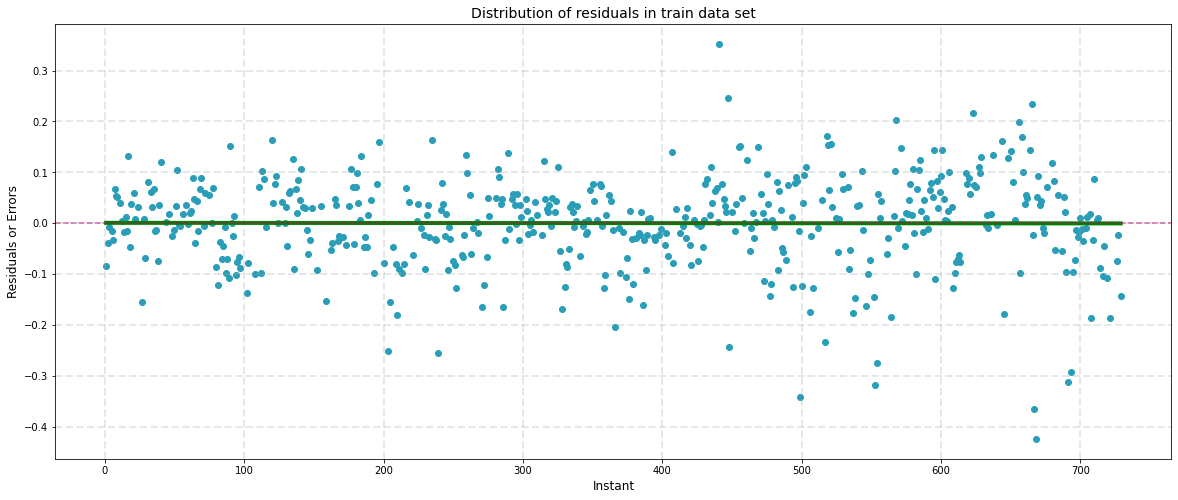

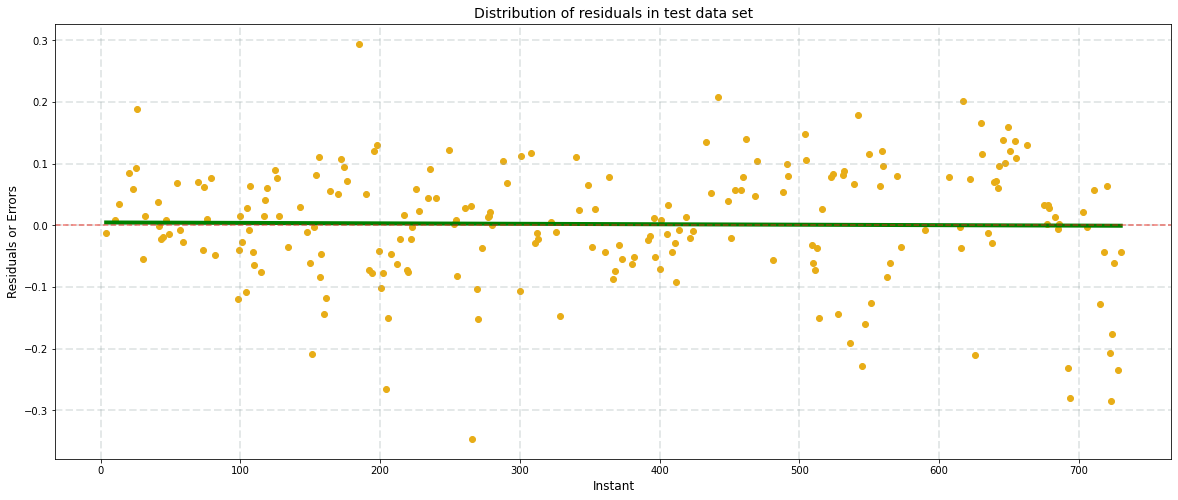

In [47]:
# Plot for Distribution of residuals in train data set
p = X_train.sort_index().index
q = train_residual[p]

plt.figure(figsize=(20,8))
plt.scatter(p,q,color='#2a9eb8')

# Following code is to fit a best line among the error points
m, b = np.polyfit(p, q, 1)
plt.plot(p, m*p + b, linewidth=4,color='green')

# Following code is to plot a line at y=0
plt.axhline(y=0, color='#bd0b73', linestyle='--', alpha=0.6)

plt.title('Distribution of residuals in train data set',fontsize=14)
plt.grid(color='#95a5a6', linestyle='--', linewidth=2, alpha=0.25)
plt.xlabel('Instant',fontsize=12)
plt.ylabel('Residuals or Errors',fontsize=12)
plt.show()


print('\n\n')


# Plot for Distribution of residuals in test data set
p = X_test.sort_index().index
q = test_residual[p]

plt.figure(figsize=(20,8))
plt.scatter(p,q,color='#e8ad17')

# Following code is to fit a best line among the error points
m, b = np.polyfit(p, q, 1)
plt.plot(p, m*p + b, linewidth=4,color='green')

# Following code is to plot a line at y=0
plt.axhline(y=0, color='#e82117', linestyle='--', alpha=0.6)

plt.title('Distribution of residuals in test data set',fontsize=14)
plt.grid(color='#95a5a6', linestyle='--', linewidth=2, alpha=0.25)
plt.xlabel('Instant',fontsize=12)
plt.ylabel('Residuals or Errors',fontsize=12)
plt.show()

### <font color='green'><b>There is hardly any best fit line passing through the error points in both train and test data sets apart from y=0<br><br>

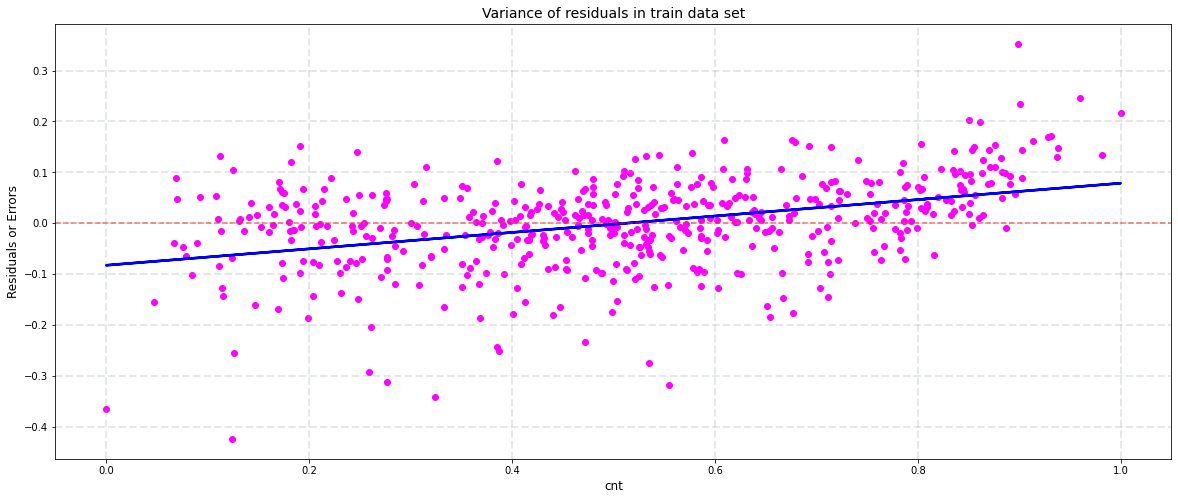

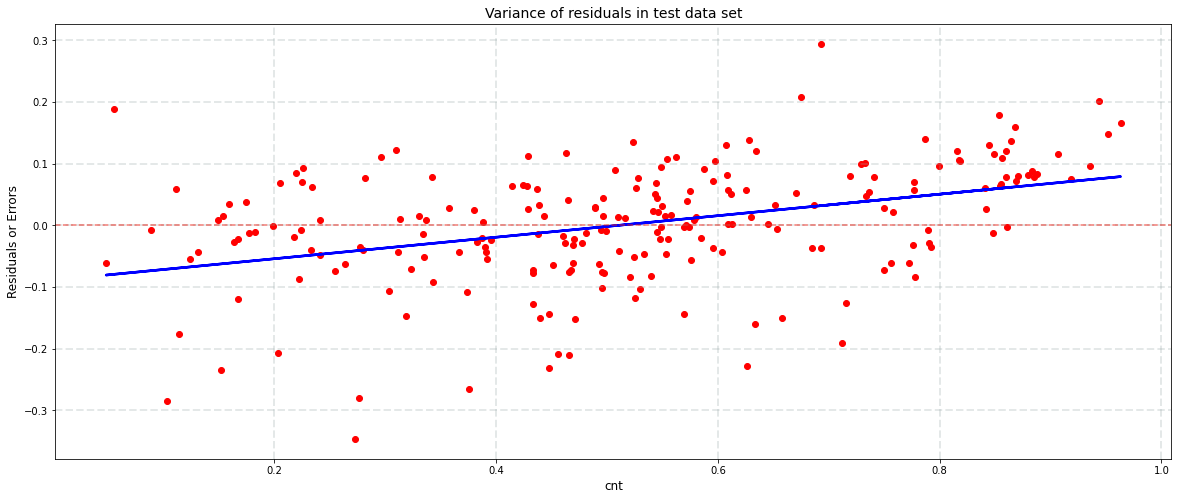

In [48]:
# Plot for Variance of residuals in train data set w.r.t. actual 'cnt' values
p = y_train
q = train_residual[p.index]

plt.figure(figsize=(20,8))
plt.scatter(p,q,color='magenta')

# Following code is to fit a best line among the error points
m, b = np.polyfit(p, q, 1)
plt.plot(p, m*p + b, linewidth=2.5,color='blue')

# Following code is to plot a line at y=0
plt.axhline(y=0, color='#e82117', linestyle='--', alpha=0.6)

plt.title('Variance of residuals in train data set',fontsize=14)
plt.grid(color='#95a5a6', linestyle='--', linewidth=2, alpha=0.25)
plt.xlabel('cnt',fontsize=12)
plt.ylabel('Residuals or Errors',fontsize=12)
plt.show()


print('\n\n')


# Plot for Variance of residuals in test data set w.r.t. actual 'cnt' values
p = y_test
q = test_residual[p.index]

plt.figure(figsize=(20,8))
plt.scatter(p,q,color='red')

# Following code is to fit a best line among the error points
m, b = np.polyfit(p, q, 1)
plt.plot(p, m*p + b, linewidth=2.5,color='blue')

# Following code is to plot a line at y=0
plt.axhline(y=0, color='#e82117', linestyle='--', alpha=0.6)

plt.title('Variance of residuals in test data set',fontsize=14)
plt.grid(color='#95a5a6', linestyle='--', linewidth=2, alpha=0.25)
plt.xlabel('cnt',fontsize=12)
plt.ylabel('Residuals or Errors',fontsize=12)
plt.show()

### <font color='green'><b>According to the above graphs, variance of residuals is constant throughout both train and test data sets.<br><br>

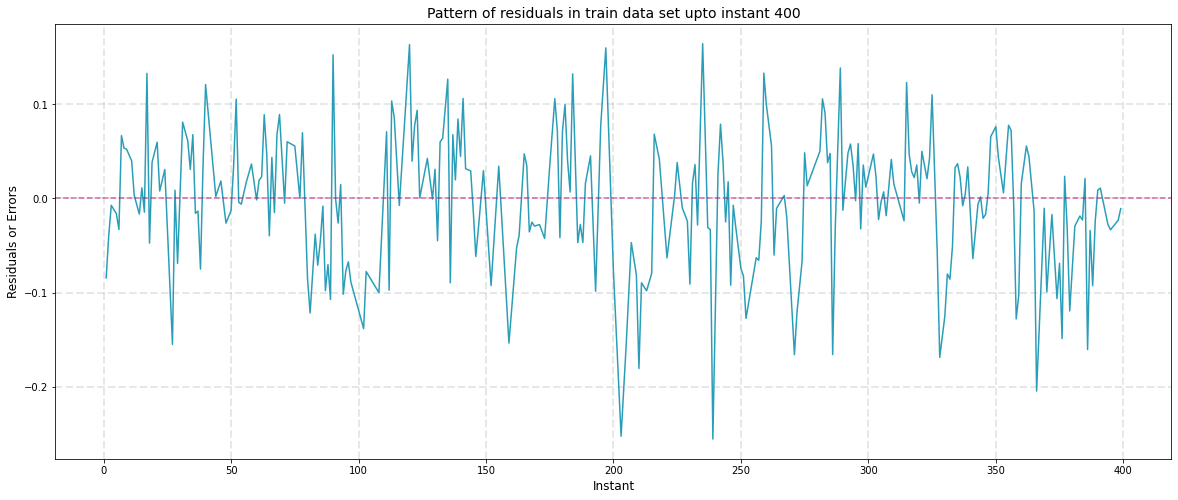

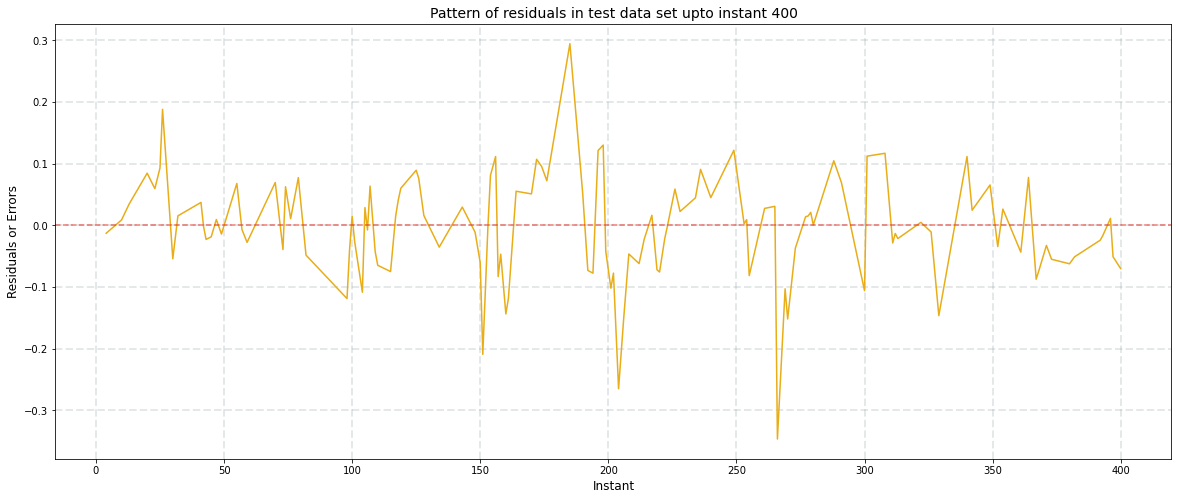

In [49]:
# Plots to check for any pattern in errors upto instant {n}

n = 400

# Plot for Distribution of residuals in train data set
p = X_train.sort_index().index[X_train.sort_index().index<=n]
q = train_residual[p]

plt.figure(figsize=(20,8))
plt.plot(p,q,color='#2a9eb8')
plt.axhline(y=0, color='#bd0b73', linestyle='--', alpha=0.6)

plt.title(f'Pattern of residuals in train data set upto instant {n}',fontsize=14)
plt.grid(color='#95a5a6', linestyle='--', linewidth=2, alpha=0.25)
plt.xlabel('Instant',fontsize=12)
plt.ylabel('Residuals or Errors',fontsize=12)
plt.show()


print('\n\n')


# Plot for Distribution of residuals in test data set
p = X_test.sort_index().index[X_test.sort_index().index<=n]
q = test_residual[p]

plt.figure(figsize=(20,8))
plt.plot(p,q,color='#e8ad17')
plt.axhline(y=0, color='#e82117', linestyle='--', alpha=0.6)

plt.title(f'Pattern of residuals in test data set upto instant {n}',fontsize=14)
plt.grid(color='#95a5a6', linestyle='--', linewidth=2, alpha=0.25)
plt.xlabel('Instant',fontsize=12)
plt.ylabel('Residuals or Errors',fontsize=12)
plt.show()

### <font color='green'><b>There is no visible pattern in appearance of errors in any of the data sets